This experiment has the following improvements on experiment #5:
- !Picks the best validation run in a callback to maximize test performance
- !Runs for 50 epochs (vs 20)
- !Runs a reduced batch size of 50 (vs 100)
- !Locks graph boundaries for Train/Val and Semanticity
- Prints out all graph data - produce Graph?
- !Prints all neurons
- Plug and play semanticity calculations

NOTE: 
- Paper [2] suggest 1024 neurons - maybe replicate


In [ ]:
#import required packages
!pip install torch torchvision
!pip install pandas openpyxl

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using device: cpu


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

def filter_classes(dataset, classes):
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in classes:
            indices.append(i)
    return torch.utils.data.Subset(dataset, indices)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the classes you want to load
selected_classes = [0,3] 
cifar_class_names = ["Aeroplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
num_classes = len(selected_classes)

# Load CIFAR10 dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to keep only the selected classes:
# Custom dataset class to remap the class labels
class CustomCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, *args, **kwargs):
        super(CustomCIFAR10, self).__init__(*args, **kwargs)

        self.label_map = {label: idx for idx, label in enumerate(selected_classes)}

        indices = [i for i, label in enumerate(self.targets) if label in selected_classes]

        self.data = self.data[indices]
        self.targets = [self.label_map[label] for label in self.targets if label in selected_classes]

# Load filtered CIFAR10 dataset using the custom dataset class
filtered_train_set = CustomCIFAR10(root='./data', train=True, download=True, transform=transform)
filtered_test_set = CustomCIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the filtered_trainset into train and validation subsets
train_size = int(0.8 * len(filtered_train_set))
val_size = len(filtered_train_set) - train_size
train_set, val_set = torch.utils.data.random_split(filtered_train_set, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(filtered_test_set, batch_size=50, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:06<00:00, 25831980.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Check that the data loaded properly

# Print the number of classes and their names for the original CIFAR-10 dataset
print("Original CIFAR-10 dataset:")
print("Number of classes:", len(full_trainset.classes))
print("Class names:", full_trainset.classes)

# Print the number of selected classes and their names for the filtered dataset
print("\nFiltered dataset:")
print("Number of selected classes:", len(selected_classes))
print("Selected class names:", [full_trainset.classes[i] for i in selected_classes])

print(f"Number of images in train loader: {len(train_loader.dataset)}")
print(f"Number of images in val loader: {len(val_loader.dataset)}")
print(f"Number of images in test loader: {len(test_loader.dataset)}")


Original CIFAR-10 dataset:
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Filtered dataset:
Number of selected classes: 2
Selected class names: ['airplane', 'cat']
Number of images in train loader: 8000
Number of images in val loader: 2000
Number of images in test loader: 2000


In [ ]:
class ToyCNN(nn.Module):
    def __init__(self, num_classes=len(selected_classes)):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ToyCNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Epoch 1, Train Loss: 0.5551, Validation Loss: 0.4283
Epoch 2, Train Loss: 0.3922, Validation Loss: 0.3671
Epoch 3, Train Loss: 0.3163, Validation Loss: 0.2850
Epoch 4, Train Loss: 0.2955, Validation Loss: 0.3060
Epoch 5, Train Loss: 0.2758, Validation Loss: 0.2597
Epoch 6, Train Loss: 0.2671, Validation Loss: 0.3036
Epoch 7, Train Loss: 0.2591, Validation Loss: 0.2395
Epoch 8, Train Loss: 0.2454, Validation Loss: 0.2390
Epoch 9, Train Loss: 0.2358, Validation Loss: 0.2475
Epoch 10, Train Loss: 0.2281, Validation Loss: 0.2406


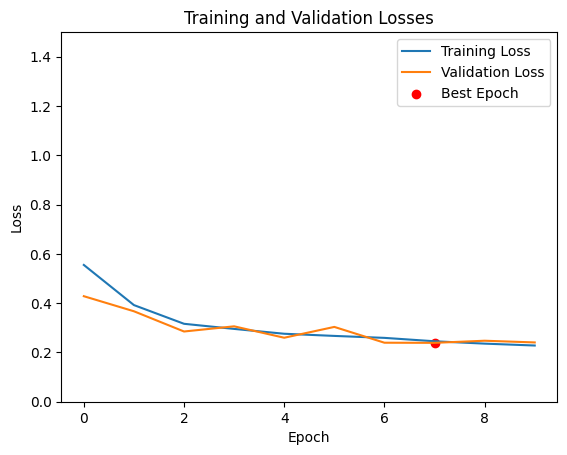

In [ ]:
import matplotlib.pyplot as plt

def train(net, train_loader, optimizer, device, criterion):
    net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    return train_loss

def validate(net, val_loader, criterion, device):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_loss = running_loss / len(val_loader)
    return val_loss

num_epochs = 10
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_weights = None

for epoch in range(num_epochs):
    train_loss = train(net, train_loader, optimizer, device, criterion)
    val_loss = validate(net, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Save the model weights if the validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = net.state_dict().copy()

#Load best validation case into the net
net.load_state_dict(best_model_weights)

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses)

# Plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")

# Add a marker for the best epoch
plt.scatter(best_epoch, val_losses[best_epoch], c='red', marker='o', label="Best Epoch")

plt.ylim(0, 1.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()


In [ ]:
def measure_polysemanticity(layer):
    activations = []

    def hook(module, input, output):
        activations.append(output)

    hook_handle = layer.register_forward_hook(hook)

    # Pass a batch of images through the network
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = net(images)

    hook_handle.remove()

    # Calculate mean activations for each neuron
    mean_activations = [torch.mean(a, dim=(0, 2, 3)).cpu().numpy() for a in activations]
    mean_activations = np.stack(mean_activations).mean(axis=0)

    return mean_activations

conv1_polysemanticity = measure_polysemanticity(net.conv1)
conv2_polysemanticity = measure_polysemanticity(net.conv2)

print("Conv1 Polysemanticity:", conv1_polysemanticity)
print("Conv2 Polysemanticity:", conv2_polysemanticity)


Conv1 Polysemanticity: [ 0.11955653 -0.5668369   0.06250564 -0.06266713 -0.07115674 -0.09151179]
Conv2 Polysemanticity: [-0.15827739 -1.1433183   0.08304066 -1.0326124  -0.4220449  -1.1552308
 -0.24481742 -0.65752804  0.18521306  0.2326765  -0.18000905  0.01353822
 -0.42932978 -0.1370304   0.33277556 -0.04275349]


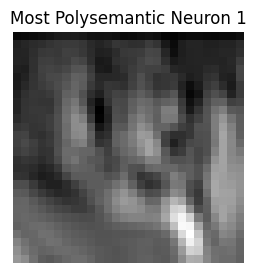

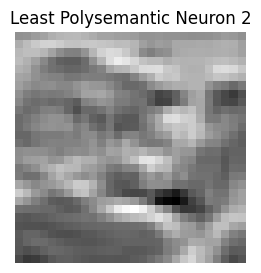

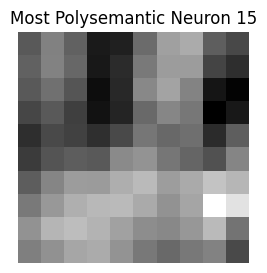

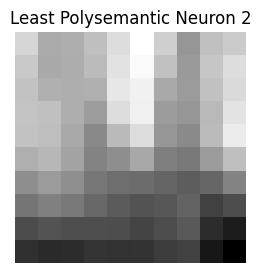

In [ ]:
import matplotlib.pyplot as plt
#displays images of polysemantic neurons - made in part with ChatGPT

def visualize_polysemantic_neurons(layer, polysemanticity, num_neurons=1):
    most_polysemantic_indices = polysemanticity.argsort()[-num_neurons:]
    least_polysemantic_indices = polysemanticity.argsort()[:num_neurons]

    activations = []

    def hook(module, input, output):
        activations.append(output)

    hook_handle = layer.register_forward_hook(hook)

    # Pass a batch of images through the network
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        _ = net(images)

    hook_handle.remove()

    for idx, title in zip([most_polysemantic_indices, least_polysemantic_indices], ['Most', 'Least']):
        if num_neurons > 1:
            fig, axs = plt.subplots(1, num_neurons, figsize=(3 * num_neurons, 3))
            for i, neuron_idx in enumerate(idx):
                feature_map = activations[0][0, neuron_idx].cpu().numpy()
                axs[i].imshow(feature_map, cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        else:
            fig, ax = plt.subplots(figsize=(3, 3))
            neuron_idx = idx[0]
            feature_map = activations[0][0, neuron_idx].cpu().numpy()
            ax.imshow(feature_map, cmap='gray')
            ax.axis('off')
            ax.set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        plt.show()

# Visualize the most and least polysemantic neurons in conv1 and conv2
visualize_polysemantic_neurons(net.conv1, conv1_polysemanticity)
visualize_polysemantic_neurons(net.conv2, conv2_polysemanticity)


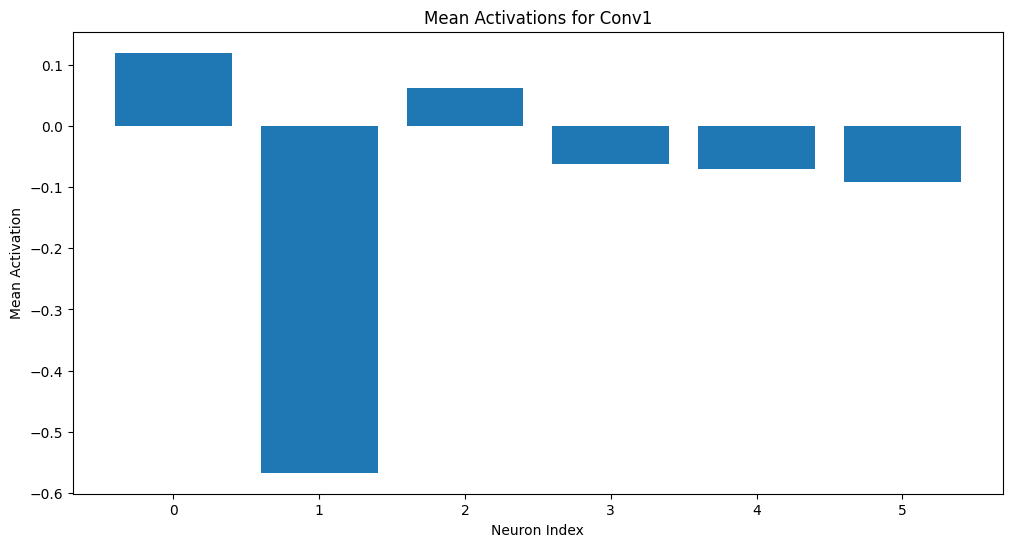

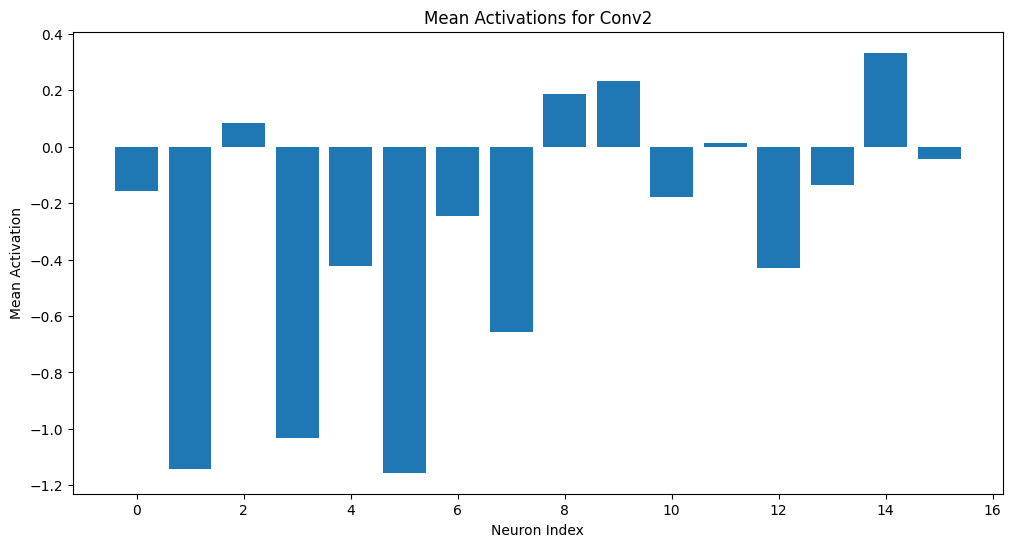

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_activations(mean_activations, layer_name):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(mean_activations)), mean_activations)
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Activation")
    plt.title(f"Mean Activations for {layer_name}")
    plt.show()

plot_mean_activations(conv1_polysemanticity, "Conv1")
plot_mean_activations(conv2_polysemanticity, "Conv2")

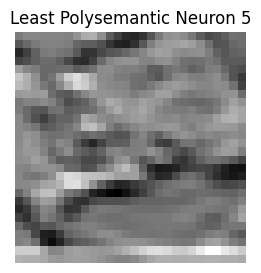

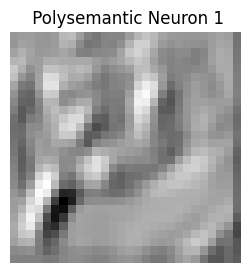

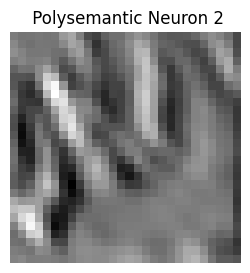

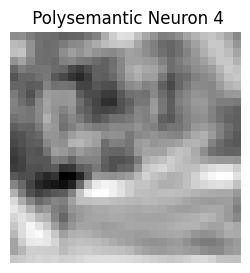

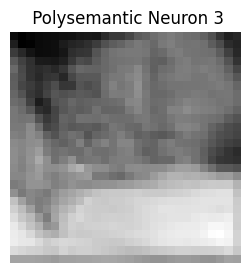

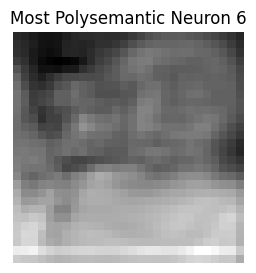

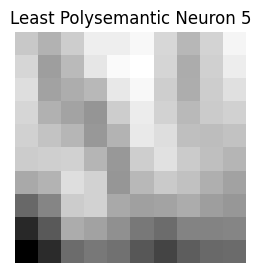

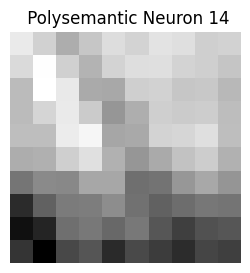

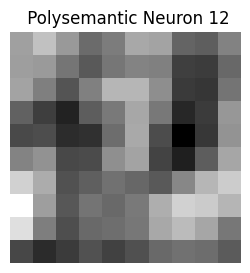

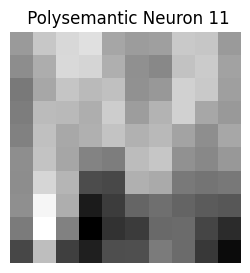

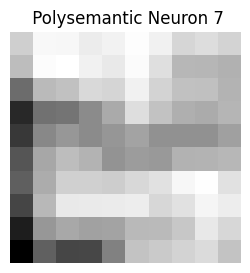

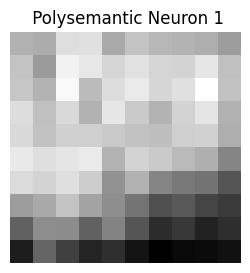

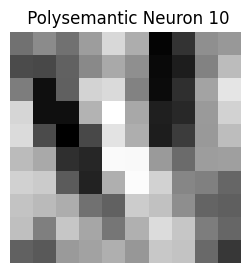

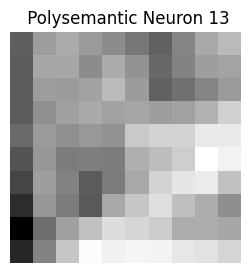

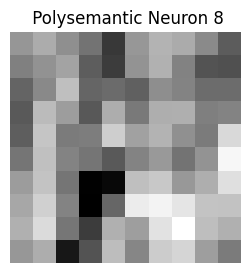

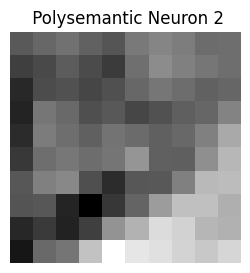

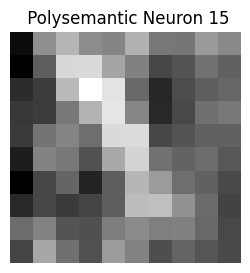

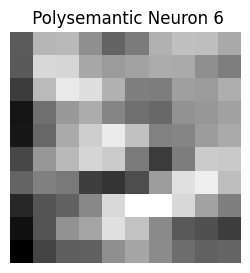

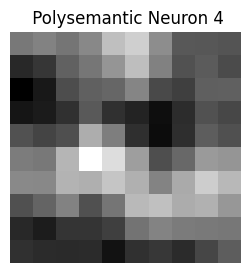

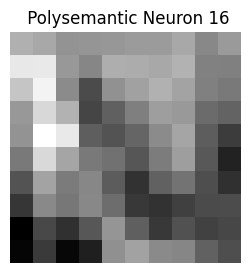

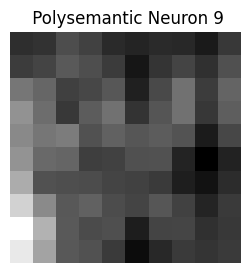

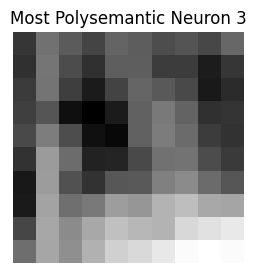

In [ ]:
#Prints every neuron in order of semanticity
import matplotlib.pyplot as plt

def visualize_polysemantic_neurons(layer, polysemanticity, num_neurons=1):
    most_polysemantic_indices = polysemanticity.argsort()[-num_neurons:]
    least_polysemantic_indices = polysemanticity.argsort()[:num_neurons]

    activations = []

    def hook(module, input, output):
        activations.append(output)

    hook_handle = layer.register_forward_hook(hook)

    # Pass a batch of images through the network
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        _ = net(images)

    hook_handle.remove()

    for idx in zip(polysemanticity.argsort()[:]):
        title = ""
        if idx == most_polysemantic_indices:
          title = "Most"
        elif idx == least_polysemantic_indices:
          title = "Least"
        if num_neurons > 1:
            fig, axs = plt.subplots(1, num_neurons, figsize=(3 * num_neurons, 3))
            for i, neuron_idx in enumerate(idx):
                feature_map = activations[0][0, neuron_idx].cpu().numpy()
                axs[i].imshow(feature_map, cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        else:
            fig, ax = plt.subplots(figsize=(3, 3))
            neuron_idx = idx[0]
            feature_map = activations[0][0, neuron_idx].cpu().numpy()
            ax.imshow(feature_map, cmap='gray')
            ax.axis('off')
            ax.set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        plt.show()

# Visualize the most and least polysemantic neurons in conv1 and conv2
visualize_polysemantic_neurons(net.conv1, conv1_polysemanticity)
visualize_polysemantic_neurons(net.conv2, conv2_polysemanticity)


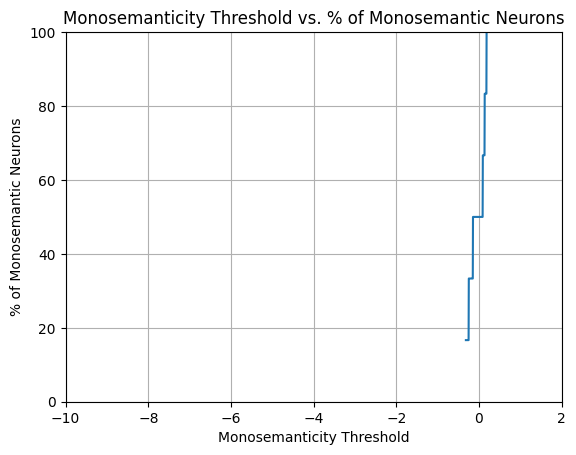

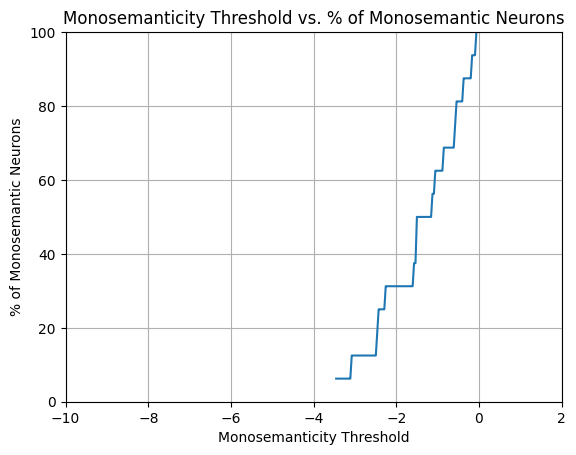

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_monosemanticity(polysemanticity, num_thresholds=100):
    thresholds = np.linspace(polysemanticity.min(), polysemanticity.max(), num_thresholds)
    percentages = []

    for threshold in thresholds:
        monosemantic_neurons = np.sum(polysemanticity <= threshold)
        percentage = (monosemantic_neurons / polysemanticity.size) * 100
        percentages.append(percentage)

    plt.plot(thresholds, percentages)
    plt.ylim(0, 100)
    plt.xlim(-10, 2)
    plt.xlabel('Monosemanticity Threshold')
    plt.ylabel('% of Monosemantic Neurons')
    plt.title('Monosemanticity Threshold vs. % of Monosemantic Neurons')
    plt.grid()
    plt.show()

    return thresholds, percentages


# Example usage with conv1_polysemanticity
conv1_thresholds, conv1_percentages = plot_monosemanticity(conv1_polysemanticity)
conv2_thresholds, conv2_percentages = plot_monosemanticity(conv2_polysemanticity)


In [ ]:
#Run a test over all data. Return % correct
def test_nn(model, device, test_loader):
    net.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)
            if i%10 == 0:
                print(f"Iteration {i}: Labels: {labels}")
                print(str(labels.size(0)) + " = labels, inputs = " + str(inputs.size(0)))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()


    return correct/total    

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)
accuracy = test_nn(net, device, test_loader)
print(str(accuracy))


Iteration 0: Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1])
50 = labels, inputs = 50
Iteration 10: Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0])
50 = labels, inputs = 50
Iteration 20: Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0])
50 = labels, inputs = 50
Iteration 30: Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0])
50 = labels, inputs = 50
0.937


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Create a dictionary with the training and validation data
training_data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
}

# Create a DataFrame with the training and validation data
training_df = pd.DataFrame(training_data)

def calculate_monosemanticity_percentages(polysemanticity, num_thresholds=100):
    thresholds = np.linspace(polysemanticity.min(), polysemanticity.max(), num_thresholds)
    percentages = []

    for threshold in thresholds:
        monosemantic_neurons = np.sum(polysemanticity <= threshold)
        percentage = (monosemantic_neurons / polysemanticity.size) * 100
        percentages.append(percentage)

    # Include a value of 0 for percentages at the initial threshold value
    percentages[0] = 0

    return thresholds, percentages

# Calculate monosemanticity percentages for conv1 and conv2
conv1_thresholds, conv1_percentages = calculate_monosemanticity_percentages(conv1_polysemanticity)
conv2_thresholds, conv2_percentages = calculate_monosemanticity_percentages(conv2_polysemanticity)

# Create a dictionary with the monosemanticity data
monosemanticity_data = {
    'Conv1 Threshold': conv1_thresholds,
    'Conv1 % Monosemantic Neurons': conv1_percentages,
    'Conv2 Threshold': conv2_thresholds,
    'Conv2 % Monosemantic Neurons': conv2_percentages,
}

# Create a DataFrame with the monosemanticity data
monosemanticity_df = pd.DataFrame(monosemanticity_data)

# Create a DataFrame with the accuracy data
accuracy_df = pd.DataFrame({'Accuracy': accuracy}, index=[0])

# Prepare the name for the output file
class_types = '_'.join([full_trainset.classes[i] for i in selected_classes])

# Save the DataFrames to an Excel file with two sheets
with pd.ExcelWriter(f"results_{class_types}.xlsx") as writer:
    training_df.to_excel(writer, sheet_name="Training and Validation", index=False)
    monosemanticity_df.to_excel(writer, sheet_name="Monosemanticity", index=False)
    accuracy_df.to_excel(writer, sheet_name="Accuracy", index=False)

# Save the Excel file to Google Drive (assuming you have mounted it)
!cp results_{class_types}.xlsx /content/drive/MyDrive/Neuro140/FinalProject/Exp_6_Output_Data/

#NOTE: Tf file name already exists, overwrite will occur

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
